# Galsyn

This notebook will go through some of the basic steps involved in utilizing methods from the galsyn library to generate synthetic images of galaxies. There are three main components that are used: a sky-detector class, a foreground star class, and a galaxy class. The ImageGenerator class acts as a convenient wrapper to all three classes.

To get sarted, we begin by importing a few libraries, a couple image transformation functions, and set the random seeds for reproducability:

In [1]:
import matplotlib.pyplot as plt
import random
import numpy
import seaborn
import torch
from galkit.functional.transform import arcsinh_stretch, fits2jpeg, to_tricolor
random.seed(0)
numpy.random.seed(0)
torch.manual_seed(0)

n_samples = 3

## Sky-Detector Noise

The SkyDetectorGenerator class is used to generate noise from the sky background and detector. The function documentation looks as follows:

In [2]:
from galsyn.sky_detector import SkyDetectorGenerator
SkyDetectorGenerator?

Init signature:
SkyDetectorGenerator(
    generator: copulas.multivariate.base.Multivariate = GaussianMultivariate(distribution="{'psfWidth_u': <class 'copulas.univariate.gamma.GammaUnivariate'>, 'psfWidth_g': <class 'copulas.univariate.gamma.GammaUnivariate'>, 'psfWidth_r': <class 'copulas.univariate.gamma.GammaUnivariate'>, 'psfWidth_i': <class 'copulas.univariate.gamma.GammaUnivariate'>, 'psfWidth_z': <class 'copulas.univariate.gamma.GammaUnivariate'>, 'psfSigma1_u': <class 'copulas.univariate.gamma.GammaUnivariate'>, 'psfSigma1_g': <class 'copulas.univariate.gamma.GammaUnivariate'>, 'psfSigma1_r': <class 'copulas.univariate.gamma.GammaUnivariate'>, 'psfSigma1_i': <class 'copulas.univariate.gamma.GammaUnivariate'>, 'psfSigma1_z': <class 'copulas.univariate.gamma.GammaUnivariate'>, 'psfSigma2_u': <class 'copulas.univariate.log_laplace.LogLaplace'>, 'psfSigma2_g': <class 'copulas.univariate.log_laplace.LogLaplace'>, 'psfSigma2_r': <class 'copulas.univariate.log_laplace.LogLaplace'>, '

If working with SDSS data, most of the parameters can be left in their default state. The *device* parameter specifies what device the data should be generated on, so it can be helpful if wanting to use a GPU to increase the performance. The *perturbation* parameter is a way of adding procedural noise to the image and the class documentation gives an example of how to incorporate such noise.

We'll begin by initializing the class object and generating random parameter for each sample:

In [3]:
sky = SkyDetectorGenerator()

kwargs = {
    'shape': (256,256),
    'filter_bands': 'irg',
    'output_counts': True,
    'apply_noise': True,
}

sky.sample(n_samples)
print(sky.data)

   psfWidth_u  psfWidth_g  psfWidth_r  psfWidth_i  psfWidth_z  psfSigma1_u  \
0    1.379646    1.281495    1.218136    0.962920    0.949229     1.506331   
1    1.449529    1.291842    1.178660    1.108368    1.011232     1.337865   
2    1.442485    1.267748    1.240125    1.081579    0.955257     1.365040   

   psfSigma1_g  psfSigma1_r  psfSigma1_i  psfSigma1_z  ...   alpha_u  \
0     1.185823     1.104307     0.832938     0.865701  ...  3.830115   
1     1.253564     1.119371     1.079628     1.023431  ...  2.773731   
2     1.221168     1.151513     0.987211     0.839376  ...  2.417461   

      beta_u   alpha_g     beta_g   alpha_r     beta_r   alpha_i     beta_i  \
0  21.777125  1.875162   8.237170  1.762375   7.580423  1.523361  10.925046   
1  11.865596  2.554017  11.945617  2.253998  12.401942  2.551398  16.620191   
2   9.250077  2.176293   9.556392  1.820478   7.598848  1.419869   6.494824   

    alpha_z     beta_z  
0  1.225254   6.454670  
1  2.004121  11.737379  
2  1.0

Most of the parameters are drawn from the SDSS Field table, although the *alpha* and *beta* columns are Moffat fits to the PSF profile.

To generate synthetic noise, we'll simply call the function, which returns a dictionary where the keys are the filter bands and the values are tensors containing the noise for each of the different samples. This can be done as follows, and we'll plot the r-band noise for the first sample:

/tmp/ipykernel_7118/105333706.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


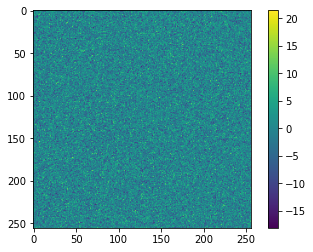

In [4]:
output_sky = sky(**kwargs)

def foo(i, filter='r'):
    img = output_sky[filter][i]
    fig, ax = plt.subplots()
    c = ax.imshow(img.squeeze())
    fig.colorbar(c, ax=ax)
    fig.show()

foo(0)

## Foreground Stars

The StarGenerator class is used for constructing foreground stars. Let's look at some of the documentation:

In [5]:
from galsyn.star import StarGenerator

StarGenerator?

Init signature:
StarGenerator(
    generator: copulas.multivariate.base.Multivariate = GaussianMultivariate(distribution="TruncatedGaussian"),
    magnitude_column: str = 'psfMag',
    magnitude_to_flux: <built-in function callable> = <function sdss_mag2flux at 0x7f5342ac0280>,
    psf_model: <built-in function callable> = DoubleGaussianPowerlawModel(b='psfB', beta='psfBeta', p0='psfP0', sigma1='psfSigma1', sigma2='psfSigma2', sigmaP='psfSigmaP'),
    device: Optional[torch.device] = None,
)
Docstring:     
Class associated with generating synthetic foreground stars.

Attributes
----------
data : DataFrame
    When the `generate` method is executed, the generated synthetic
    sample is stored as this attribute.

device : torch.device
    The device to generate data on.

magnitude_column : Text
    The name of the column associated with the total magnitude of the star.

magnitude_to_flux : callable
    A function that converts the magnitude to flux.

psf_model : callable
    The analyt

If working with SDSS, most of the parameters can be left with their default values. The *device* parameter is important to note again, and the *psf_model* parameter is used to specify what point-spread function we want to use. Using the default copula, any of the options in the *galsyn/star/psf.py* file can be used. Let's go ahead and initialize this class using the DoubleGaussianPowerlawModel that is used by SDSS:

In [6]:
from galsyn.star import StarGenerator
from galsyn.star.psf import DoubleGaussianPowerlawModel

star = StarGenerator(psf_model=DoubleGaussianPowerlawModel())

We'll need to pass in the Sky-Detector object to get the PSF information. We can also output a signal-to-noise map as well as a stellar mask based on a S/N cutoff. The S/N value is calculated using the model flux rather than Poisson sampled flux.

In [7]:
output_star = star(
    sky_detector=sky,
    output_star_s2n=True,
    output_star_mask=True,
    oversample=2,
    stars_per_pixel=2e-4,
    s2n_mask_threshold=1,
    **kwargs
)

We can go ahead and plot our results

/tmp/ipykernel_7118/2635888986.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


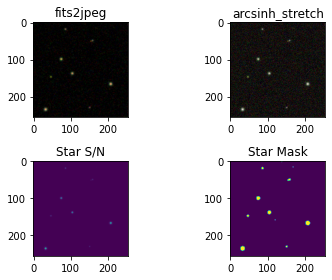

In [8]:
imag = torch.stack([output_sky[k] + output_star['flux'][k] for k in 'irg'], dim=1)

def foo(i):
    img1  = fits2jpeg(imag[i], desaturate=True)
    img2  = arcsinh_stretch(imag[i])
    fig, ax = plt.subplots(ncols=2, nrows=2)
    ax[0,0].imshow(img1.T)
    ax[0,0].set_title('fits2jpeg')
    ax[0,1].imshow(img2.T)
    ax[0,1].set_title('arcsinh_stretch')
    ax[1,0].imshow(output_star['s2n'][i].T)
    ax[1,0].set_title('Star S/N')
    ax[1,1].imshow(output_star['mask'][i].T)
    ax[1,1].set_title('Star Mask')
    fig.tight_layout()
    fig.show()

foo(0)

## Galaxies

The final component to include are galaxies, and the parent class is the Dataset class. Two implemented methods for constructing galaxies are Gadotti and MendezAbreu, which are based on the published data in [Gadotti (2009)](https://ui.adsabs.harvard.edu/abs/2009MNRAS.393.1531G/abstract) and [Mendez-Abreu et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..32M/abstract).

Compared to the previous classes we'll likely want to specify the multivariate copula to use for generating the data. A nice interface to loading some of the stored datasets in the __file__ folter is the *load_local_generator* function, where we pass in the name of the function and it returns the multivariate copula.

Let's look at the documentation for the MendezAbreu class:

In [9]:
from galsyn.galaxy.dataset import MendezAbreu as Galaxy
Galaxy?

Init signature:
Galaxy(
    generator=GaussianMultivariate(distribution="{'μ0_bulge_z': <class 'copulas.univariate.gaussian.GaussianUnivariate'>, 'μ0_bulge_i': <class 'copulas.univariate.gaussian.GaussianUnivariate'>, 'μ0_bulge_r': <class 'copulas.univariate.gaussian.GaussianUnivariate'>, 'μ0_bulge_g': <class 'copulas.univariate.gaussian.GaussianUnivariate'>, 'μ0_bulge_u': <class 'copulas.univariate.gaussian.GaussianUnivariate'>, 'r_bulge': <class 'copulas.univariate.truncated_gaussian.TruncatedGaussian'>, 'n_bulge': <class 'copulas.univariate.uniform.UniformUnivariate'>, 'μ0_disk_z': <class 'copulas.univariate.gaussian.GaussianUnivariate'>, 'μ0_disk_i': <class 'copulas.univariate.gaussian.GaussianUnivariate'>, 'μ0_disk_r': <class 'copulas.univariate.gaussian.GaussianUnivariate'>, 'μ0_disk_g': <class 'copulas.univariate.gaussian.GaussianUnivariate'>, 'μ0_disk_u': <class 'copulas.univariate.gaussian.GaussianUnivariate'>, 'hi_disk': <class 'copulas.univariate.truncated_gaussian.Truncated

and it's parent class:

In [10]:
from galsyn.galaxy.dataset import Dataset
Dataset?

Init signature:
Dataset(
    generator: copulas.multivariate.base.Multivariate,
    columns: Dict[str, Union[str, Dict]],
    profile: Union[<built-in function callable>, Dict],
    flux_to_magnitude: <built-in function callable> = <function pogson_flux2mag at 0x7f53465dbc10>,
    magnitude_to_flux: <built-in function callable> = <function pogson_mag2flux at 0x7f53465dbca0>,
    device: Optional[torch.device] = None,
    geometry_sampler: <built-in function callable> = GeometrySampler(centroid_sampler=<function GeometrySampler.<lambda> at 0x7f53427388b0>, pa_bar_sampler=<function GeometrySampler.<lambda> at 0x7f5342738af0>, pa_bulge_sampler=<function GeometrySampler.<lambda> at 0x7f5342738b80>, pa_disk_sampler=<function GeometrySampler.<lambda> at 0x7f5342738c10>, q_bulge_sampler=<function GeometrySampler.<lambda> at 0x7f5342738ca0>, q_disk_sampler=<function GeometrySampler.<lambda> at 0x7f5342738d30>),
    perturbation: Optional[Dict[str, <built-in function callable>]] = {'disk_arm': 

Two important parameters worth pointing out are the spiral and pertubation parameters. The spiral parameter is used for generating spiral patterns, while the perturbation allows for including procedural noise.

Let's go ahead and create an object for generating galaxies with a bulge, disk, and disk break using the Mendez-Abreu dataset. We'll specify that there'll be three spiral arms for each galaxy, but you can check out the torch.multinomial function for randomly generating such values.

In [11]:
from galsyn.galaxy.spiral import Ringermacher
from galsyn.utils import load_local_generator

galaxy = Galaxy(
    generator=load_local_generator('mendez-abreu_2017_bulge_disk_dbreak.pkl'),
    spiral = Ringermacher(arm_count = lambda size, device : torch.tensor(size * [3,], device=device))
)

We'll need to set some isoA for scaling purposes. There are several methods implemented in *galsyn.galaxy.photometric*, such as using the Petrosian radius and finding when the flux reaches a certain value.

Let's go ahead and set the isoA value to be where the galaxy flux reaches the sky background level in the r-band and generate the associated galaxy image:

In [12]:
from galsyn.galaxy.photometric import IsoFlux

output_galaxy = galaxy(
    size = n_samples,
    sky_detector=sky,
    isoA_metric=IsoFlux(),
    isoA_value = sky.noise_level(0.396, 'r', output_counts=False),
    isoA_scale=1,
    output_arm_mask = True,
    output_arm_s2n = True,
    output_galaxy_mask = True,
    output_galaxy_s2n = True,
    output_projection = True,
    oversample = 2,
    **kwargs
)

We can plot up the results, and include the spiral arm mask and the S/N ratio of the galaxy flux:

/tmp/ipykernel_7118/118539049.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


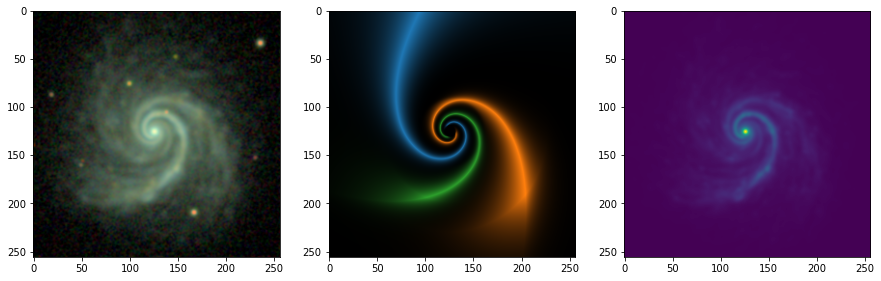

In [13]:
def foo(i):
    image = torch.cat([output_galaxy['flux'][i][k] + output_star['flux'][k][i] + output_sky[k][i] for k in kwargs['filter_bands']])
    image = fits2jpeg(image).permute(1,2,0)

    mask_arm = output_galaxy['arm_mask'][i]
    if mask_arm.nelement() == 0:
        mask_arm = torch.zeros(256,256)
    else:
        mask_arm = to_tricolor(output_galaxy['arm_mask'][i], seaborn.color_palette('tab10'))
        mask_arm = mask_arm / mask_arm.max()

    galaxy_s2n = output_galaxy['galaxy_s2n'][i]

    fig, ax = plt.subplots(ncols=3, figsize=(15,5))
    ax[0].imshow(image)
    ax[1].imshow(mask_arm.squeeze())
    ax[2].imshow(galaxy_s2n.squeeze())
    fig.show()

foo(0)